In [26]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from utils import *
from tests import *
%matplotlib inline

In [27]:
"""
An L-layered binary classifier neural network.
"""


def backward(AL, Y, caches):
    """
    Back-propagation for the model. Has internal ReLUs and a sigmoid for the L-th layer.
    
    Arguments:
    :param AL: 
                - Probability vector resultant of forward propagation.
    :param Y: 
                - Truth vector provided by the user.
    :param caches: List of caches of shape (linear_cache, activation_cache) of length L
                - The caches contain the saved data from the forward propagation segment.
    
    Returns:
    :return gradients: 
    """
    gradients = {}           # initialization of the gradients dictionary
    L = len(caches)          # number of layers
    print(str(L))
    m = AL.shape[1]          # number of data samples (total training samples)
    Y = Y.reshape(AL.shape)  # reshape Y to be the same as AL for matrix multiplication
    # Calculate L-th layer derivative to initiate the back-propagation:
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    # Access the L-th layer caches:
    current_cache = caches[L - 1]
    # Add the L-th layer sigmoid gradients to our dictionary:
    dA_prev_temp, dW_temp, db_temp = backward_activation(dAL, current_cache, "sigmoid")
    gradients["dA" + str(L - 1)] = dA_prev_temp
    gradients["dW" + str(L)] = dW_temp
    gradients["db" + str(L)] = db_temp
    
    # Calculate each gradient for the internal ReLU layers:
    for l in reversed(range(L - 1)):
        # Update the cache:
        current_cache = caches[l]
        # Add dA, dW and db to our gradients dictionary:
        dA_prev_temp, dW_temp, db_temp = \
            backward_activation(gradients["dA" + str(l + 1)], current_cache, "ReLU")
        gradients["dA" + str(l)] = dA_prev_temp
        gradients["dW" + str(l + 1)] = dW_temp
        gradients["db" + str(l + 1)] = db_temp
    return gradients


def backward_linear(dZ, full_cache):
    """
    The linear segment of back-propagation for an arbitrary layer l.
    
    Arguments:
    :param dZ: 
                - Gradient of the cost with respect to the linear output for the layer l.
    :param linear_cache: tuple of shape (A_prev, W, b)
                - The saved values from forward propagation.
    :param m: 
                - Count of all training samples.

    Returns:
    :return dW: same shape as W
                - Gradient of the cost with respect to W (weights).
    :return db: same shape as b
                - Gradient of the cost with respect to b (biases).
    :return dA: same shape as A_prev
                - Gradient of the cost with respect to the activation (of the previous layer, l - 1).
    """
    
    # Open the cache:
    linear_cache, activation_cache = full_cache
    # Fetch W, b, and A_prev from the cache saved from our forward step:
    A_prev, W, b = linear_cache
    # Calculate the count of our training samples:
    m = A_prev.shape[1]
    # Derive weights:
    dW = (1 / m) * np.dot(dZ, linear_cache[0].T)
    # Derive biases:
    db = (1 / m) * np.sum(dZ)
    # Derive the activations:
    dA_prev = np.dot(linear_cache[1].T, dZ)
    
    return dA_prev, dW, db


def backward_activation(dA, full_cache, activation="ReLU"):
    """
    Back-propagation segment for post-linear activation.
    
    Arguments:
    :param dA: 
                - Post-activation gradient for current layer l.
    :param full_cache:
                - Both linear_- and activation_-caches.
    :param activation: string
                - The type of activation function to used, either "ReLU" or "sigmoid".
    
    Returns:
    :return dW: same shape as W
                - Gradient of the cost with respect to W (weights).
    :return db: same shape as b
                - Gradient of the cost with respect to b (biases).
    :return dA_prev: same shape as A_prev
                - Gradient of the cost with respect to the activation (of the previous layer, l - 1).
    """
    # Unpack the cache:
    linear_cache, activation_cache = full_cache
    
    # Split into the appropriate activation function:
    if activation == "ReLU":
        # Derive sigmoid:
        dZ = sigmoid_backwards(dA, activation_cache)
        # Back-propagate on the linear values post-dZ:
        dA_prev, dW, db = backward_linear(dZ, full_cache)
    elif activation == "sigmoid":
        # Derive sigmoid:
        dZ = relu_backwards(dA, activation_cache)
        # Back-propagate on the linear values post-dZ:
        dA_prev, dW, db = backward_linear(dZ, full_cache)
    return dA_prev, dW, db


def calc_cost(AL, Y):
    # Count the number of training samples:
    m = Y.shape[1]
    # Evaluate the logarithmic cost function:
    cost = - (1 / m) * np.sum(np.dot(Y, np.log(AL.T) + np.dot((1 - Y), np.log(1 - AL.T))))
    # Reformat the cost:
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost


def forward(X, parameters):
    # Z = forward_activity(A, W, b)
    # A = forward_activation(Z, activation)
    # We need to return an array of caches so we can use the saved values for backprop
    # We return the the final activity, AL, A[L], of our forward propagation step so that
    #   it can be used as the input for back-propagation
    A = X
    L = len(parameters) // 2
    caches = []
    
    # Loop over every layer:
    for l in range(1, L):
        # Reset our A_prev to reference the A from the previous iteration:
        A_prev = A
        
        A, cache = forward_activation(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "ReLU")
        
        # Append the full cache to the list of caches:
        caches.append(cache)
    # Save the weights of the last layer into the parameters dictionary:
    AL, cache = forward_activation(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
    caches.append(cache)
    assert(AL.shape == (1, X.shape[1]))
    return AL, caches


def forward_activation(A_prev, W, b, activation="ReLU"):
    """
    Helper which handles calling the appropriate activation function.
    
    :param Z: 
    :param W: 
    :param b: 
    :param activation: 
    :return: 
    """
    
    if activation == "ReLU":
        Z, linear_cache = forward_linear(A_prev, W, b)
        A, activation_cache = relu(Z)
    elif activation == "sigmoid":
        Z, linear_cache = forward_linear(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    assert(A.shape == (W.shape[0], Z.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache


def forward_linear(A, W, b):
    """
    The linear segment of a layer's forward propagation.
    
    Arguments:
    :param A: (size of previous layer, number of data samples)
                -activations from the previous layer (or X, input data, for the 0-th layer)
    :param W: numpy array of shape (size of current layer, size of previous layer)
                -weights matrix
    :param b: numpy array of shape (size of current layer, 1)
                -bias vector
    
    Returns:
    :return Z:
                -the input of the activation function (also known as the pre-activation parameter)
    :return cache: python dictionary containing "A", "W", and "b"
                -stores forward-pass data for use later during backwards propagation
    """
    
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    assert Z.shape == (W.shape[0], A.shape[1]), "Not getting a proper dimension for Z (activity)"
    return Z, cache


def initialize_parameters(layers):
    """
    Initializes the weights and biases for every layer of an l-layered neural network.
    
    Arguments:
    :param layers: a Python array where the index is the layer and the value is the number of units in layer index
    
    Returns:
    :return parameters: Python dictionary containing "W1", "b1", ..., "WL", "bL"
                         - Wl: weights for l with shape: (layers[l], layers[l - 1])
                         - bl: biases  for l with shape: (layers[l], 1)
    """
    L = len(layers)
    parameters = {}
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layers[l], layers[l - 1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layers[l], 1))
        assert(parameters["W" + str(l)].shape == (layers[l], layers[l - 1]))
        assert(parameters["b" + str(l)].shape == (layers[l], 1))
    return parameters


def train(X, Y, layers, learning_rate, num_iterations=2500):
    parameters = initialize_parameters(layers)
    
    for i in range(0, num_iterations):
        # Run the model:
        AL, caches = forward(X, parameters)
        # print(str(AL))
        
        # Calculate the cost:
        cost = calc_cost(AL, Y)
        
        # Back-propagate the model:
        gradients = backward(AL, Y, caches)
        
        # Run gradient descent and update parameters:
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        # Print the cost at every iteration:
        print("Cost at iteration " + str(i) + ": " + str(cost))
    return parameters


def update_parameters(parameters, gradients, learning_rate=0.001):
    L = len(parameters) // 2
    
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * \
            gradients["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * \
            gradients["db" + str(l + 1)]
    return parameters

y = 0. It's a non-cat picture.
train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


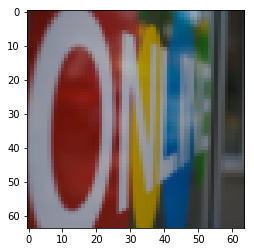

In [28]:
from utils import load_data

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# %autoreload 2

np.random.seed(1)
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

index = 49
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

In [25]:




# Create the dimensions of the model with respect to the dataset
# layers_dims = [12288, 20, 7, 5, 1]  # 4-layer model
# parameters = train(train_x, train_y, layers_dims, 0.0075, num_iterations = 2)

4
Cost at iteration 0: 32.95293704395234
4
Cost at iteration 1: 32.843764891086735
